In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
confusion_matrix,
roc_curve,
auc
)

import cloudpickle

sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv("/content/Leads.csv")

In [ ]:
df['Converted'] = pd.to_numeric(df['Converted'], errors='coerce')

In [ ]:
df = df[df['Converted'].notna()]

In [ ]:
# Categorical columns (excluding Converted automatically)
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Numeric columns
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(0)

In [ ]:
print(df['Converted'].value_counts())
print("Conversion Rate:", df['Converted'].mean())

Converted
0    5679
1    3561
Name: count, dtype: int64
Conversion Rate: 0.3853896103896104


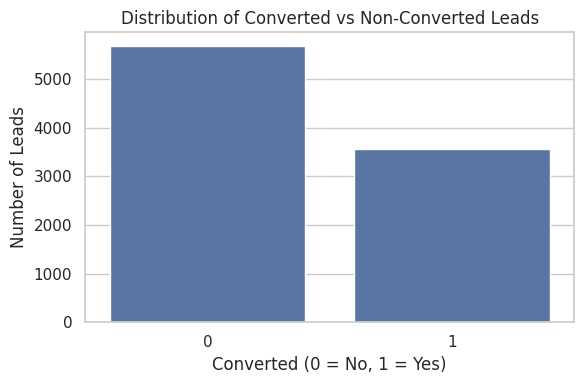

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Converted', data=df)
plt.title("Distribution of Converted vs Non-Converted Leads")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Number of Leads")
plt.tight_layout()
plt.show()

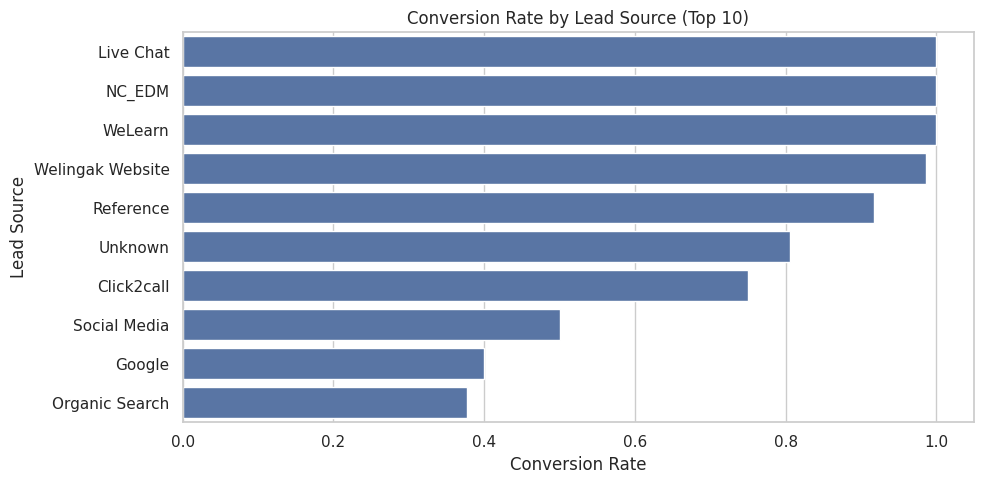

In [ ]:
conv_by_source = (
    df.groupby('Lead Source', as_index=False)['Converted']
    .mean()
    .sort_values(by='Converted', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=conv_by_source,
    x='Converted',
    y='Lead Source'
)
plt.title("Conversion Rate by Lead Source (Top 10)")
plt.xlabel("Conversion Rate")
plt.ylabel("Lead Source")
plt.tight_layout()
plt.show()

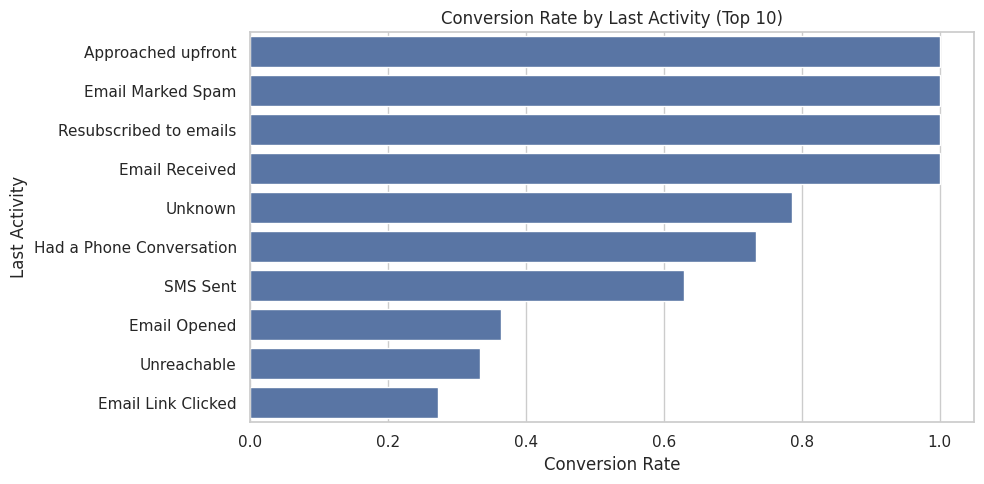

In [ ]:
conv_by_activity = (
    df.groupby('Last Activity', as_index=False)['Converted']
    .mean()
    .sort_values(by='Converted', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=conv_by_activity,
    x='Converted',
    y='Last Activity'
)
plt.title("Conversion Rate by Last Activity (Top 10)")
plt.xlabel("Conversion Rate")
plt.ylabel("Last Activity")
plt.tight_layout()
plt.show()

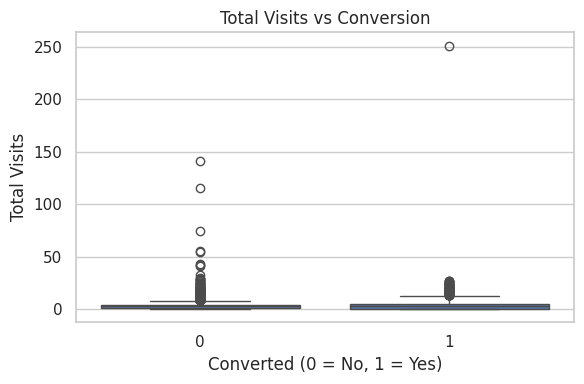

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x='Converted',
    y='TotalVisits'
)
plt.title("Total Visits vs Conversion")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Total Visits")
plt.tight_layout()
plt.show()

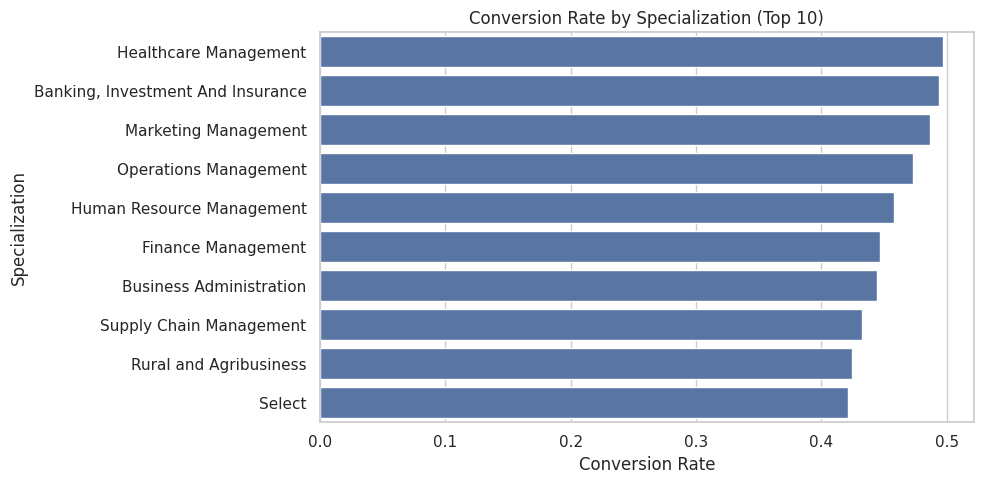

In [ ]:
conv_by_spec = (
    df.groupby('Specialization', as_index=False)['Converted']
    .mean()
    .sort_values(by='Converted', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=conv_by_spec,
    x='Converted',
    y='Specialization'
)
plt.title("Conversion Rate by Specialization (Top 10)")
plt.xlabel("Conversion Rate")
plt.ylabel("Specialization")
plt.tight_layout()
plt.show()

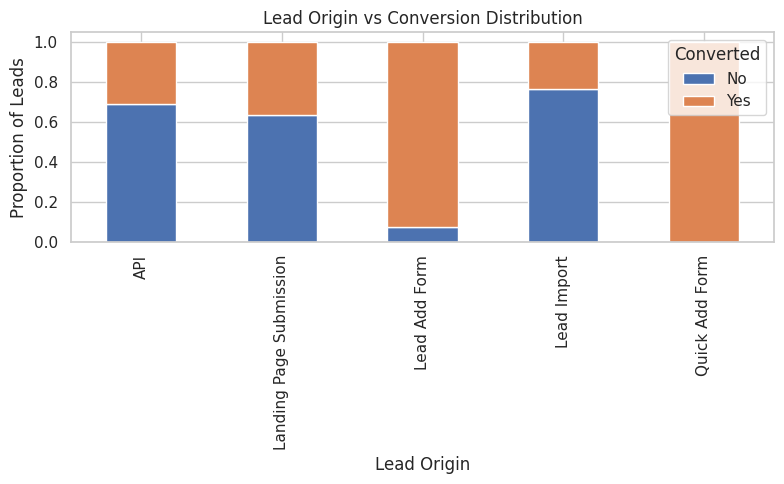

In [ ]:
lead_origin_ct = pd.crosstab(
    df['Lead Origin'],
    df['Converted'],
    normalize='index'
)

lead_origin_ct.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)
plt.title("Lead Origin vs Conversion Distribution")
plt.xlabel("Lead Origin")
plt.ylabel("Proportion of Leads")
plt.legend(title="Converted", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

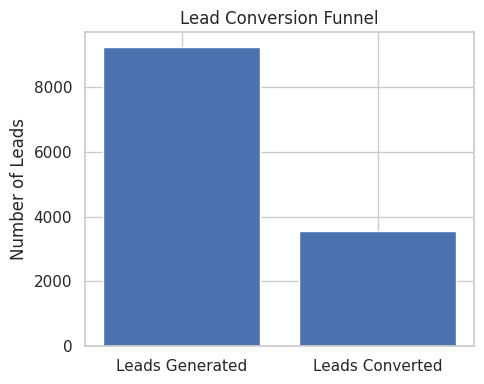

In [ ]:
funnel_data = {
    'Leads Generated': len(df),
    'Leads Converted': df['Converted'].sum()
}

plt.figure(figsize=(5,4))
plt.bar(funnel_data.keys(), funnel_data.values())
plt.title("Lead Conversion Funnel")
plt.ylabel("Number of Leads")
plt.tight_layout()
plt.show()

In [ ]:
print(df.shape)
print(df['Converted'].value_counts())
print(df['Converted'].mean())

(9240, 37)
Converted
0    5679
1    3561
Name: count, dtype: int64
0.3853896103896104


In [ ]:
# Replace 'Select' with NaN
df = df.replace('Select', np.nan)

In [ ]:
# Handle categorical missing values
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

In [ ]:
df['Engagement_Score'] = (
    0.4 * df['TotalVisits'] +
    0.3 * df['Page Views Per Visit'] +
    0.3 * df['Total Time Spent on Website']
)

In [ ]:
df['High_Engagement'] = np.where(
    df['Total Time Spent on Website'] >
    df['Total Time Spent on Website'].median(),
    1, 0
)

In [ ]:
df['Visit_Frequency'] = pd.cut(
    df['TotalVisits'],
    bins=[0, 1, 3, 10, np.inf],
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [ ]:
id_cols = ['Prospect ID', 'Lead Number']

df.drop(columns=[col for col in id_cols if col in df.columns], inplace=True)

In [ ]:
df.select_dtypes(include='object').columns


Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Last Activity', 'Country', 'Specialization',
       'How did you hear about X Education', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [ ]:
cat_features = [
    'Lead Source',
    'Lead Origin',
    'Last Activity',
    'Specialization',
    'Visit_Frequency'
]

df_encoded = pd.get_dummies(
    df,
    columns=cat_features,
    drop_first=True
)

In [ ]:
print(df_encoded.dtypes.value_counts())
print(df_encoded.isnull().sum().sum())
print(df_encoded.head())

bool       63
object     25
float64     5
int64       3
Name: count, dtype: int64
0
  Do Not Email Do Not Call  Converted  TotalVisits  \
0           No          No          0          0.0   
1           No          No          0          5.0   
2           No          No          1          2.0   
3           No          No          0          1.0   
4           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  Country  \
0                            0                   0.0  Unknown   
1                          674                   2.5    India   
2                         1532                   2.0    India   
3                          305                   1.0    India   
4                         1428                   1.0    India   

  How did you hear about X Education What is your current occupation  \
0                            Unknown                      Unemployed   
1                            Unknown                    

In [ ]:
drop_cols = [
    'Country',
    'How did you hear about X Education',
    'What matters most to you in choosing a course'
]

df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns], inplace=True)

In [ ]:
df_encoded = pd.get_dummies(
    df_encoded,
    columns=[
        'What is your current occupation',
        'Do Not Email',
        'Do Not Call'
    ],
    drop_first=True
)

In [ ]:
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [ ]:
print(df_encoded.dtypes.value_counts())
print(df_encoded.isnull().sum().sum())

int64      74
object     19
float64     5
Name: count, dtype: int64
0


In [ ]:
obj_cols = df_encoded.select_dtypes(include='object').columns
obj_cols

Index(['Search', 'Magazine', 'Newspaper Article', 'X Education Forums',
       'Newspaper', 'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [ ]:
final_drop_cols = [
    'Search', 'Magazine', 'Newspaper', 'Newspaper Article',
    'X Education Forums', 'Digital Advertisement',
    'Through Recommendations',

    'Receive More Updates About Our Courses',
    'Update me on Supply Chain Content',
    'Get updates on DM Content',
    'I agree to pay the amount through cheque',
    'A free copy of Mastering The Interview',

    'Tags', 'Lead Quality', 'Lead Profile',
    'Last Notable Activity',

    'City',

    'Asymmetrique Activity Index',
    'Asymmetrique Profile Index'
]

df_encoded.drop(columns=[c for c in final_drop_cols if c in df_encoded.columns], inplace=True)

In [ ]:
y = df_encoded['Converted']
X = df_encoded.drop('Converted', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [ ]:
y_probs = pipeline.predict_proba(X_test)[:,1]
lead_score = (y_probs * 100).round(0)

In [ ]:
# Default prediction using 0.5 threshold
y_pred_default = (y_probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("Precision:", precision_score(y_test, y_pred_default))
print("Recall:", recall_score(y_test, y_pred_default))
print("F1 Score:", f1_score(y_test, y_pred_default))

Accuracy: 0.8098845598845599
Precision: 0.775178026449644
Recall: 0.7134831460674157
F1 Score: 0.7430521696733301


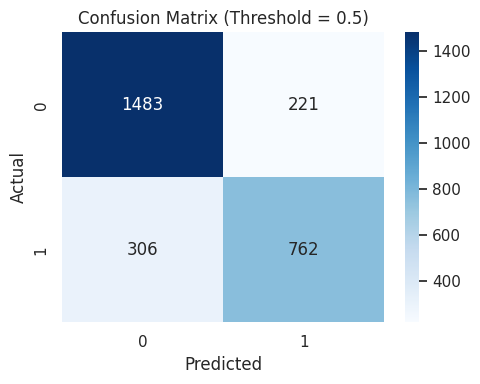

In [ ]:
cm = confusion_matrix(y_test, y_pred_default)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.tight_layout()
plt.show()

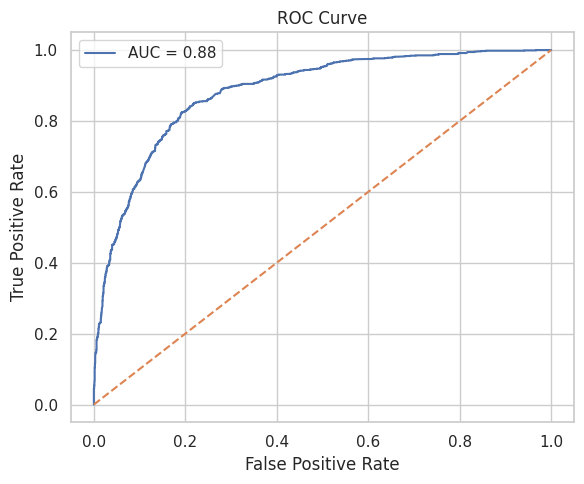

ROC-AUC Score: 0.8834294389935117


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

print("ROC-AUC Score:", roc_auc)

In [ ]:
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds_to_test:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold: {t}")
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))


Threshold: 0.3
Precision: 0.7023901310717039
Recall: 0.852996254681648
F1: 0.7704016913319239

Threshold: 0.4
Precision: 0.7466666666666667
Recall: 0.7865168539325843
F1: 0.7660738714090287

Threshold: 0.5
Precision: 0.775178026449644
Recall: 0.7134831460674157
F1: 0.7430521696733301

Threshold: 0.6
Precision: 0.8050541516245487
Recall: 0.6264044943820225
F1: 0.7045813586097947

Threshold: 0.7
Precision: 0.8323699421965318
Recall: 0.5393258426966292
F1: 0.6545454545454545


In [ ]:
aggressive_threshold = 0.3
y_pred_aggressive = (y_probs >= aggressive_threshold).astype(int)

print("Aggressive Strategy")
print("Precision:", precision_score(y_test, y_pred_aggressive))
print("Recall:", recall_score(y_test, y_pred_aggressive))

Aggressive Strategy
Precision: 0.7023901310717039
Recall: 0.852996254681648


In [ ]:
conservative_threshold = 0.7
y_pred_conservative = (y_probs >= conservative_threshold).astype(int)

print("Conservative Strategy")
print("Precision:", precision_score(y_test, y_pred_conservative))
print("Recall:", recall_score(y_test, y_pred_conservative))

Conservative Strategy
Precision: 0.8323699421965318
Recall: 0.5393258426966292


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': pipeline.named_steps['logreg'].coef_[0]
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(
    by='Abs_Coefficient', ascending=False
)

feature_importance.head(10)

,Feature,Coefficient,Abs_Coefficient
3,Asymmetrique Activity Score,1.320909,1.320909
4,Asymmetrique Profile Score,-1.254193,1.254193
74,What is your current occupation_Unknown,-0.838180,0.838180
40,Last Activity_Olark Chat Conversation,-0.738898,0.738898
66,Specialization_Unknown,-0.594275,0.594275
32,Last Activity_Converted to Lead,-0.551789,0.551789
75,What is your current occupation_Working Profes...,0.551114,0.551114
67,Visit_Frequency_Medium,-0.546714,0.546714
1,Total Time Spent on Website,0.527070,0.527070
5,Engagement_Score,0.525379,0.525379


In [ ]:
lead_scored_df = X_test.copy()
lead_scored_df['Actual_Converted'] = y_test.values
lead_scored_df['Predicted_Probability'] = y_probs
lead_scored_df['Lead_Score'] = (y_probs * 100).round(0)

lead_scored_df.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Engagement_Score,High_Engagement,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,...,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Do Not Email_Yes,Do Not Call_Yes,Actual_Converted,Predicted_Probability,Lead_Score
8305,0.0,0,0.0,17.0,15.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.178157,18.0
1591,2.0,1069,2.0,15.0,15.0,322.1,1,0,0,1,...,0,0,1,0,0,0,0,1,0.845919,85.0
8604,20.0,165,5.0,15.0,18.0,59.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0.527136,53.0
1333,1.0,471,1.0,16.0,17.0,142.0,1,1,0,0,...,0,0,0,1,0,0,0,0,0.018388,2.0
4260,1.0,2,1.0,0.0,0.0,1.3,0,1,0,0,...,0,0,1,0,0,0,0,0,0.017778,2.0


In [ ]:
final_lead_data = lead_scored_df.copy()

# Optional: sort by highest lead score first
final_lead_data = final_lead_data.sort_values(
    by='Lead_Score', ascending=False
)

final_lead_data.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Engagement_Score,High_Engagement,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,...,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Do Not Email_Yes,Do Not Call_Yes,Actual_Converted,Predicted_Probability,Lead_Score
3095,5.0,1925,5.0,0.0,0.0,581.0,1,0,0,1,...,0,0,0,0,1,0,0,1,0.997054,100.0
2656,0.0,1721,0.0,0.0,0.0,516.3,1,0,0,0,...,0,0,0,0,1,0,0,1,0.999245,100.0
7327,1.0,967,1.0,15.0,13.0,290.8,1,0,0,0,...,0,0,1,0,0,0,0,1,0.998715,100.0
8074,0.0,1650,0.0,14.0,19.0,495.0,1,0,0,0,...,0,0,0,0,1,0,0,1,0.999636,100.0
4782,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,1,0,0,1,0.997506,100.0


In [ ]:
final_lead_data.to_csv(
    "Final_Lead_Scored_Data.csv",
    index=False
)

print("Final dataset saved as Final_Lead_Scored_Data.csv")

Final dataset saved as Final_Lead_Scored_Data.csv
